# Explore SnowEX Depth Data

In [1]:
#import modules
import os
import geopandas as gpd
import pandas as pd 
import numpy as np
from shapely.geometry import Polygon
import rioxarray
import matplotlib.pyplot as plt
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData
from snowexsql.conversions import query_to_geopandas
import matplotlib as mpl
import matplotlib.pyplot as pyplot
import warnings
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.enums import Resampling
import xarray as xa
from numpy import inf
from datetime import date

warnings.filterwarnings('ignore')
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

### Create unique bounding box based on query

In [2]:
def create_bounding(database,column,query,outputfolder):
    unique = query.unique()
    for val in unique:
        val_select = column == val
        val_filtered = database[val_select]
        
        x = val_filtered["easting"]
        y = val_filtered["northing"]
        cords = x_min, y_min, x_max, y_max = (min(x),min(y),max(x),max(y))
        gpd.GeoDataFrame(pd.DataFrame(['p1'], columns = ['geom']),crs = 'epsg:32612',geometry = [bbox(min(y), min(x), max(y),max(x))]).to_file(os.path.join(outputfolder,str(val)) +'.shp')                            
    
    for file in os.listdir(outputfolder):
        if file.endswith(".shp"):
            shape_file = os.path.join(outputfolder,file)
            s_file = gpd.read_file(shape_file)
            ax = s_file.plot()
            s_file.plot(ax=ax)
            plt.title(str(os.path.basename(shape_file)[:-4]))

def bbox(minlat,minlon,maxlat,maxlon):                                                                                                                  
    return Polygon([[minlon,minlat],[minlon,maxlat],
    [maxlon,maxlat],[maxlon,minlat]])

#### Setting up directory

In [3]:
#set main directory
drec = direc = "/home/jovyan/snow_ex/data"

#shapefile directory
shape_output = os.path.join(direc,"shapefiles")

#### Get Magnaprobe Data

In [4]:
q = session.query(PointData).filter(
    PointData.type == 'depth').filter(
    PointData.instrument == 'magnaprobe'
)
magnaprobe = query_to_geopandas(q, engine)
#magnaprobe.plot(marker='.', cmap='Blues')
#plt.title(f'{magnaprobe.loc[0].instrument}: {magnaprobe.shape[0]} points');

#### Set Variable for function

In [5]:
column = magnaprobe["date"]
query = magnaprobe[column == date(2020, 2, 1)]['date']
folder = os.path.join(direc, 'ou')

#### Call create_bounding Function

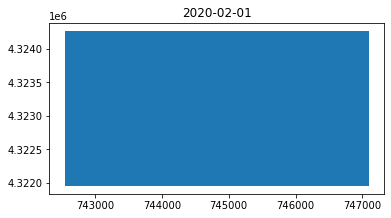

In [6]:
create_bounding(magnaprobe,column, query, folder)

### Subset data with shapefile

In [7]:
def subset_data(database,shapefile):
    shape_loc = shapefile
    shape_file = gpd.read_file(shape_loc)
    shape_bound = shape_file.geometry[0]
    subset = database[database.within(shape_bound)]
    subset.plot(marker='.', cmap='OrRd')
    plt.title("Area of interest")

#### Set up variavles

In [8]:
shape_directory = os.path.join(folder,"2020-02-01.shp")
database = magnaprobe[magnaprobe["date"] == date(2020, 2, 1)]

#### Call sebset_data function

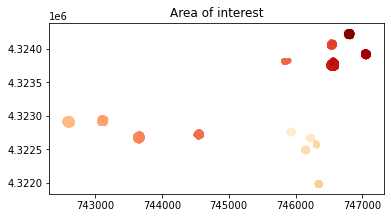

In [9]:
subset_data(database,shape_directory)

2. Function to compare GPR depths and Magnaprobe using a shapefile and SnowEx-Database

In [10]:
# Inverse Distance Weighting Interpolation
def magnoprobe_vs_gpr(magnaprobe_dataset,gpr_dataset,shapefile):
    list = [magnaprobe_dataset,gpr_dataset]
    n_file = gpd.read_file(shapefile)
    polygon = n_file.geometry[0]
    mag_points = list[1][list[1].within(polygon)] 
    gpr_points = list[1][list[1].within(polygon)]
    z = simple_idw(gpr_points.easting, gpr_points.northing, gpr_points.value, mag_points.easting, mag_points.northing)
    mag_points['depthGPR'] = z
    
    err = mag_points.value-mag_points.depthGPR
    mag_points['error'] = err 
    r = np.corrcoef(mag_points.value,mag_points.depthGPR)
    #print('The correlation is', round(r[0,1],2))
    # Calculate the Mean Error
    bias = np.mean(mag_points.error)
    #print('The bias is', round(bias,2), 'cm')
    # Calculate the Mean Absolute Error
    mae = np.mean(np.abs(mag_points.error))
    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(np.mean((mag_points.error)**2))
    #print('The rmse is', round(rmse,2), 'cm')
    # Compute the Regression Line
    m, b = np. polyfit(mag_points.value,mag_points.depthGPR, 1)

    fig, (ax3, ax2, ax1) = plt.subplots(1, 3,figsize=(15,6))
    # Plot the Correlation
    #plt.figure(0)
    ax1.plot(mag_points.value,mag_points.depthGPR,'o', color='lightskyblue')
    ax1.plot(mag_points.value, m*mag_points.value+ b,'r')
    ax1.set_xlabel('Probe Depth [cm]')
    ax1.set_ylabel('GPR Depth [cm]')
    ax1.text(0.2,0.9, ("RMSE = " + str(round(rmse,2)) + ' cm'), horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
    ax1.text(0.2,0.8, ("Bias = " + str(round(bias,2)))+ ' cm', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
    ax1.text(0.2,0.7, ("r = " + str(round(r[0,1],2))), horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)

    # Plot a Histogram of the Errors
    #plt.figure(1)
    ax2.hist(mag_points.error, density=True, bins=10, edgecolor='black',color='lightskyblue')  # density=False would make counts
    ax2.set_ylabel('PDF')
    ax2.set_xlabel('Error [cm]');
    #ax2.vlines(0, 0, round(ax2.get_ylim()[1], ndigits=4), 'k', linestyle="--")

    # Get the Matplotlib Axes object from the dataframe object, color points by snow depth value
    ax = mag_points.plot(ax = ax3,column='error', legend=True, cmap='RdBu')


    # Use non-scientific notation for x and y ticks
    ax.ticklabel_format(style='plain', useOffset=False)

    # Set the various plots x/y labels and title.
    ax.set_title("Probed Depth - GPR Depth[cm]")
    ax.set_xlabel('Easting [m]')
    ax.set_ylabel('Northing [m]')
    
def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)
    weights = 1.0 / dist
    weights[weights == inf] = 0
    weights /= weights.sum(axis=0)
    zi = np.dot(weights.T, z)
    return zi

def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1]) 
    return np.hypot(d0, d1)


#### Get GPR_Dataset

In [11]:
q = session.query(PointData).filter(
    PointData.type == 'depth').filter(
    PointData.instrument == 'pulse EKKO Pro multi-polarization 1 GHz GPR'
)
gpr = query_to_geopandas(q, engine)
#gpr.plot(marker='+', cmap='inferno')
#plt.title(f'{gpr.loc[0].instrument}: {gpr.shape[0]} points');

#### Call magnaprobe_vs_gpr Function

In [3]:
magnoprobe_vs_gpr(magnaprobe,gpr,os.path.join(shape_output,"Pit_2S16_20200208.shp"))

NameError: name 'magnaprobe' is not defined

### Clip of ASO data with magnaprobe

In [22]:
def aso_vs_magnaprobe(aso_location,database):
    aso_raster = rioxarray.open_rasterio(aso_location,masked=True)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
    #plot the raster
    aso_raster.sel(band=1).plot.imshow(ax=ax1,cmap='PuBu')
    #plot the magnoprobe vector
    database.plot(ax=ax1,cmap='ocean')
    aso_overlap = aso_raster.rio.clip(database.geometry)
    aso_overlap.sel(band=1).plot.imshow(ax=ax2,cmap='ocean')
    #database['overlap'] = aso_overlap
    #database.head()


In [23]:
aso_location = os.path.join(direc,"ASO_GrandMesa_2020Feb1-2_snowdepth_3m.tif")
aso_data = xa.open_rasterio(aso_location)

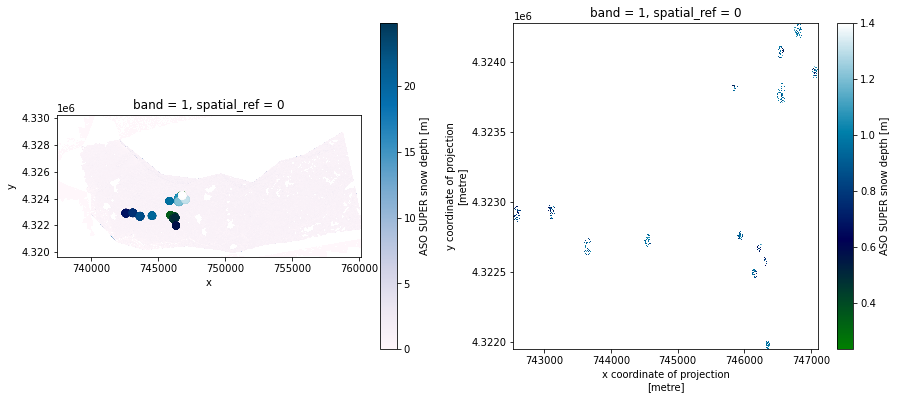

In [24]:
aso_vs_magnaprobe(aso_location,database)

### Extract ASO depth with Magnoprobe points

In [56]:
def aso_vs_magnaprobe(aso_location,database):
    aso_raster = rioxarray.open_rasterio(aso_location,masked=True)
    aso_ras = rio.open(aso_location)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
    #plot the raster
    aso_raster.sel(band=1).plot.imshow(ax=ax1,cmap='PuBu')
    #plot the magnoprobe vector
    database.plot(ax=ax1,cmap='ocean')
    aso_overlap = aso_raster.rio.clip(database.geometry)
    aso_overlap.sel(band=1).plot.imshow(ax=ax2,cmap='ocean')
    #for point in database.geometry:
        #print(point.xy[0][0],point.xy[1][0])
     
    depth = []
    for point in database.geometry:
        x = point.xy[0][0]
        y = point.xy[1][0]
        row, col = aso_ras.index(x,y)
        
        

    #database['overlap'] = aso_overlap
    #database.head()


<xarray.DataArray (band: 1, y: 777, x: 1519)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 4.324e+06 4.324e+06 ... 4.322e+06 4.322e+06
  * x            (x) float64 7.425e+05 7.425e+05 ... 7.471e+05 7.471e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ASO SUPER snow depth [m]


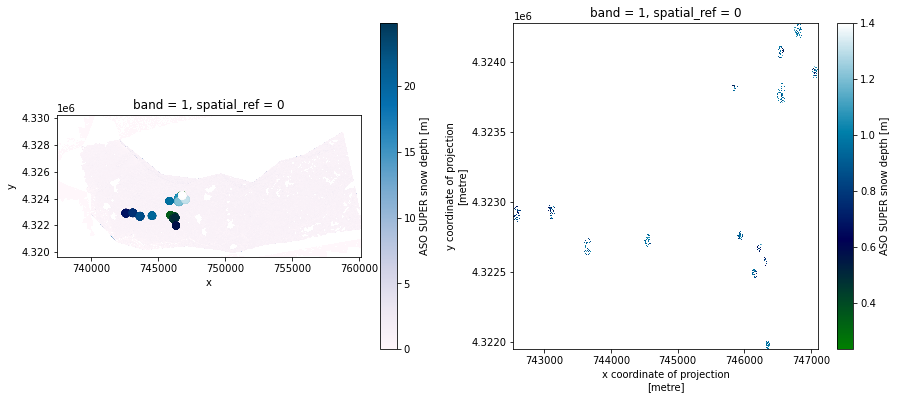

In [57]:
aso_vs_magnaprobe(aso_location,database)